In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
# Read satellite data
def read_satellite_data(satellite):
    # --- Main Execution ---
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    df = df[df['veg_class'].isin([11, 12, 13, 14])]
    return df

In [3]:
## Read AVHRR data
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]

In [6]:
## Combine effect size data with AVHRR data
effect_size = pd.read_csv(f"../data/effect_size/avhrr/effect_size_ate.csv")
effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')
effect_size = effect_size.rename(columns=lambda x: x.replace("w1", "82_16"))

effect_size_82_00 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_82_99_ate.csv")
effect_size_00_16 = pd.read_csv(f"../data/effect_size/avhrr/effect_size_00_16_ate.csv")
effect_size_82_00 = effect_size_82_00.rename(columns=lambda x: x.replace("w1", "82_99"))
effect_size_00_16 = effect_size_00_16.rename(columns=lambda x: x.replace("w1", "00_16"))
effect_size_82_00_16 = pd.merge(effect_size_82_00, effect_size_00_16, on=['latitude', 'longitude'], how='inner')
effect_size = pd.merge(effect_size_82_00_16, effect_size, on=['latitude', 'longitude'], how='inner')

In [7]:
## Divide into three regions
effect_size_hot_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
effect_size_cold_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]

In [8]:
## Plot effect size of 3 periods
def plot_effect_size(dfs, names):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    color_map = {
        # 'sos': '#ff69b4',
        'spring_t': '#e9967a',
        # 'summer_t': '#d47264',
        'autumn_t': '#c14d48',
        # 'spring_p': '#8ec1da',
        'summer_p': '#4d91c4',
        # 'autumn_p': '#2066a8',
        # 'spring_r': '#d8c3e2',
        # 'summer_r': '#a991c1',
        'autumn_r': '#7a5fa0'
    }

    label_map = {
        'spring_t': 'Spring T',
        # 'summer_t': 'Summer temperature',
        'autumn_t': 'Autumn T',
        'summer_p': 'Summer P',
        # 'spring_r': 'Spring SRiation',
        # 'summer_r': 'Summer SRiation',
        'autumn_r': 'Autumn SR'
    }

    n = len(dfs)
    fig, axes = plt.subplots(n, 1, figsize=(8, 3*n), sharey=True)

    if n == 1:
        axes = [axes]

    for i, (df, name) in enumerate(zip(dfs, names)):
        # print(name)
        plot_two_periods_subplot(axes[i], df, name, color_map, label_map)
        if i < n-1:
            axes[i].set_xticklabels([])
        axes[i].set_ylim(-0.40, 0.50)

    # Custom legend
    legend_elements = [
        Patch(facecolor='white', edgecolor='black', label='1982-2016', linewidth=1.0),
        Patch(facecolor='white', hatch='/', edgecolor='#3d3d3d', label='1982-1999', linewidth=1.0),
        Patch(facecolor='white', hatch='..', edgecolor='#3d3d3d', label='2000-2016', linewidth=1.0)
    ]
    axes[0].legend(handles=legend_elements, fontsize=11, frameon=False)

    fig.text(0.01, 0.5, 'Effect Size', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout(rect=[0.05, 0, 1, 1])
    plt.show()
    return fig


In [15]:
## Temporal Comparison of Effect Sizes with Standard Errors and t-Tests
def plot_two_periods_subplot(ax, df, name, color_map, label_map):
    import numpy as np
    import pandas as pd
    import re
    from scipy.stats import ttest_ind
    # Regex to capture variable name and period
    pattern = re.compile(r"^(.*)_es_(\d{2}_\d{2})$")
    vars_periods = {}
    for col in df.columns:
        match = pattern.match(col)
        if match:
            var, period = match.group(1), match.group(2)
            if var not in label_map:
                continue
            if var not in vars_periods:
                vars_periods[var] = {}
            vars_periods[var][period] = col
            
    # Helper to compute mean + SE
    def mean_and_se(series):
        values = series.dropna()
        if len(values) == 0:
            return np.nan, np.nan
        if len(values) == 1:
            return values.iloc[0], np.nan
        return values.mean(), values.std(ddof=1) / np.sqrt(len(values))

    # Collect results
    group_means = {"82–99": {}, "00–16": {}, "82_16": {}}
    group_se = {"82–99": {}, "00–16": {}, "82_16": {}}
    p_values = {}

    for var, period_cols in vars_periods.items():
        # print(period_cols)
        vals1 = vals2 = None
        if "82_99" in period_cols:
            mean1, se1 = mean_and_se(df[period_cols["82_99"]])
            group_means["82–99"][var], group_se["82–99"][var] = mean1, se1
            vals1 = df[period_cols["82_99"]].dropna()
        if "00_16" in period_cols:
            mean2, se2 = mean_and_se(df[period_cols["00_16"]])
            group_means["00–16"][var], group_se["00–16"][var] = mean2, se2
            vals2 = df[period_cols["00_16"]].dropna()
        if "82_16" in period_cols:
            mean, se = mean_and_se(df[period_cols["82_16"]])
            group_means["82_16"][var], group_se["82_16"][var] = mean, se
            vals = df[period_cols["82_16"]].dropna()

        # significance test
        if len(vals1) > 1 and len(vals2) > 1:
            stat, p = ttest_ind(vals1, vals2, equal_var=True, nan_policy="omit")
            p_values[var] = p
        else:
            p_values[var] = np.nan

    # Bar plot setup
    variables = list(group_means["82_16"].keys())
    x = np.arange(len(variables))
    width = 0.25

    vals = [group_means["82_16"][var] for var in variables]
    se = [group_se["82_16"][var] for var in variables]
    vals1 = [group_means["82–99"][var] for var in variables]
    se1 = [group_se["82–99"][var] for var in variables]
    vals2 = [group_means["00–16"][var] for var in variables]
    se2 = [group_se["00–16"][var] for var in variables]

    colors = [color_map.get(var, "black") for var in variables]

    # Plot 1982–2016
    ax.bar(
        x - width, vals, width=width, color=colors,
        label="1982–2016", yerr=[2*np.array(se)], capsize=5
    )

    # Plot 1982–1999
    ax.bar(
        x, vals1, width=width, color=colors, hatch="/",
        edgecolor="#3d3d3d", linewidth=0.8, label="1982–1999",
        yerr=[2*np.array(se1)], capsize=5, alpha=0.85
    )
    # # Plot 2000–2016
    # ax.bar(
    #     x + width, vals2, width=width, color=colors, hatch="//", 
    #     edgecolor="#3d3d3d", linewidth=0.8, label="2000–2016",
    #     yerr=[2*np.array(se2)], capsize=5, alpha=0.8
    # )
    # Plot 2000–2016
    ax.bar(
        x + width, vals2, width=width, color=colors, hatch="...", 
        edgecolor="#3d3d3d", linewidth=0.8, label="2000–2016",
        yerr=[2*np.array(se2)], capsize=5, alpha=0.7
    )

    # Add significance markers (* for p<0.05, ** for p<0.01)
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    bracket_height = 0.03 * y_range   # fixed size for all brackets
    bracket_gap = 0.03 * y_range      # gap between bar top and bracket

    for i, var in enumerate(variables):
        # print(var)
        # print(p_values[var])
        if var in p_values and not np.isnan(p_values[var]):
            p = p_values[var]
            # print(p)
            if p < 0.05:  # only plot if significant
                sig_symbol = "**" if p < 0.01 else "*"

                # bar heights
                y1 = vals1[i] + (se1[i] if se1[i] else 0)
                y2 = vals2[i] + (se2[i] if se2[i] else 0)

                if y1 >= 0 or y2 >= 0:
                    # at least one bar positive → put bracket above
                    y_base = max(y1, y2) + bracket_gap
                    text_va = "bottom"
                    bracket_dir = +1
                else:
                    # both negative → put bracket below
                    y_base = min(y1, y2) - bracket_gap
                    text_va = "top"
                    bracket_dir = -1

                # x positions for the two bars
                x_left = i# - width/2
                x_right = i + width

                # bracket top position
                if bracket_dir == +1:  # above
                    y_bracket = y_base + bracket_height
                else:  # below
                    y_bracket = y_base - bracket_height

                # draw ] [
                ax.plot([x_left, x_left], [y_base, y_bracket], color="black", linewidth=1)
                ax.plot([x_left, x_right], [y_bracket, y_bracket], color="black", linewidth=1)
                ax.plot([x_right, x_right], [y_base, y_bracket], color="black", linewidth=1)

                # put significance symbol above the middle
                ax.text(
                    (x_left + x_right) / 2,
                    y_bracket + (0.01 * y_range * bracket_dir),
                    sig_symbol,
                    ha="center", va=text_va,
                    fontsize=14, color="black"
                )


    # Add text labels above/below the 1982–2016 bars
    for i, val in enumerate(vals):
        if np.isnan(val):
            continue
        xpos = x[i] - width     # position of the 82–16 bar
        ypos = val
        offset = 0.02 * (y_max - y_min)  # small vertical offset

        if val >= 0:
            ax.text(
                xpos, ypos + offset,
                f"{val:.2f}", ha="center", va="bottom", fontsize=10
            )
        else:
            ax.text(
                xpos, ypos - offset,
                f"{val:.2f}", ha="center", va="top", fontsize=10
            )


    # Decorations
    ax.text(0.01, 0.9, name, transform=ax.transAxes, fontsize=12, ha="left", va="top")
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels([label_map.get(var, var) for var in variables], rotation=45, ha="right", fontsize=12)
    ax.tick_params(axis="y", labelsize=12)


Plot Fig. 3a

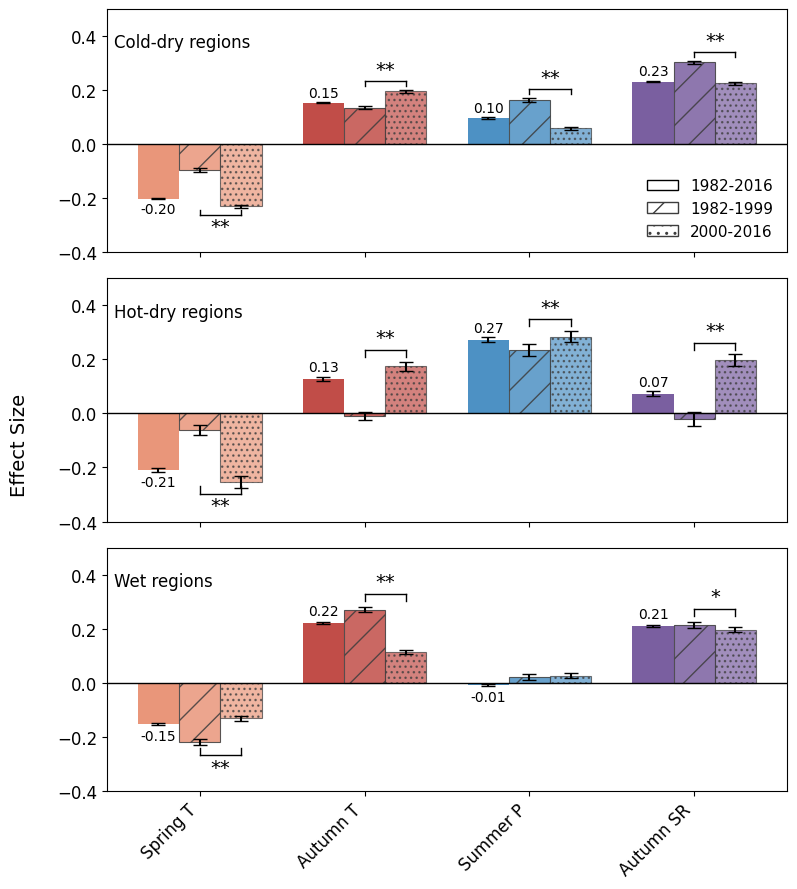

In [16]:
dfs = [effect_size_cold_dry, effect_size_hot_dry, effect_size_wet]
fig = plot_effect_size(
    dfs,
    ["Cold-dry regions", "Hot-dry regions", "Wet regions"]
)
fig.savefig("../results/figure3/fig3_1.png", dpi=300, bbox_inches='tight')

In [25]:
## Plot dominant driver map

In [20]:
## Read AVHRR data
satellite = "avhrr" 
df = read_satellite_data(satellite)

eos_cols = [col for col in df.columns if 'eos' in col]
t_cols = [col for col in df.columns if 'annual_t' in col]
p_cols = [col for col in df.columns if 'annual_p' in col]

years = [str(y) for y in range(1982, 2017)]
cols = years
# df = df[[col for col in eos_cols + t_cols + p_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
t_cols_df = [col for col in df.columns if 'annual_t' in col]
df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
df_climate = df[['annual_t', 'annual_p', 'latitude', 'longitude']]

In [21]:
## Read effect size data and combine
effect_size = pd.read_csv(f"../results/figure3/effect_size/avhrr/effect_size_ate.csv")
effect_size = pd.merge(effect_size, df_climate, on=['latitude', 'longitude'], how='inner')

In [22]:
## Divide into three regions
effect_size_hot_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] > 7.25)]
effect_size_cold_dry = effect_size[(effect_size['annual_p'] < 0.9) & (effect_size['annual_t'] < 7.25)]
effect_size_wet = effect_size[effect_size['annual_p'] > 0.9]

In [23]:
## Plot dominant driver map
import matplotlib.pyplot as plt
import rasterio as rs
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ------------------------------
# Labels
# ------------------------------
DRIVER_LABEL_MAP = {
    "sos_es_w1": "SOS",
    "spring_t_es_w1": "Spring T",
    "summer_t_es_w1": "Summer T",
    "autumn_t_es_w1": "Autumn T",
    "spring_p_es_w1": "Spring P",
    "summer_p_es_w1": "Summer P",
    "autumn_p_es_w1": "Autumn P",
    "spring_r_es_w1": "Spring SR",
    "summer_r_es_w1": "Summer SR",
    "autumn_r_es_w1": "Autumn SR",
}

# ------------------------------
# Determine dominant driver using only _w1 columns
# ------------------------------
def assign_dominant_driver(df):
    use_cols = list(DRIVER_LABEL_MAP.keys())
    use_cols = [c for c in use_cols if c in df.columns]

    df_combined = df.copy()
    df_combined["dominant_driver"] = df_combined[use_cols].idxmax(axis=1)

    driver_codes = {name: i for i, name in enumerate(use_cols)}
    df_combined["dominant_driver_code"] = df_combined["dominant_driver"].map(lambda x: driver_codes[x])
    
    return df_combined, driver_codes

# ------------------------------
# Rasterization
# ------------------------------
def rasterize_driver(gdf, transform, width, height, crs):
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf["dominant_driver_code"]))
    # driver_raster = rasterize(
    #     shapes=shapes,
    #     out_shape=(height, width),
    #     transform=transform,
    #     fill=-1,
    #     dtype="int32"
    # )
    driver_raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=np.nan,
        dtype='float32'
    )
    # print(f"[DEBUG] Pixels with valid driver: {np.count_nonzero(driver_raster != -1)}")
    
    # --- Land mask clipping (inside rasterize_data) ---
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import box
    
    # Load Natural Earth land polygons
    ne_path = shpreader.natural_earth(
        resolution="110m",
        category="physical",
        name="land"
    )
    land = gpd.read_file(ne_path).to_crs(crs)
    
    # Clip to raster extent
    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left, bottom, right, top)
    land = gpd.clip(land, gpd.GeoDataFrame(geometry=[raster_bounds], crs=crs))
    
    # Rasterize land mask
    land_mask = rasterize(
        [(geom, 1) for geom in land.geometry],
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )
    
    # Apply land masking
    driver_raster = np.where(land_mask == 1, driver_raster, np.nan)
    print("[DEBUG] Pixels after land mask:", np.count_nonzero(~np.isnan(driver_raster)))
    
    return driver_raster

# ------------------------------
# Plot raster + inset bar chart
# ------------------------------
def show_driver_raster(driver_raster, transform, driver_colors, driver_labels):
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())
    ax.coastlines()

    # Circular mask
    theta = np.linspace(0,2*np.pi,100)
    center, radius = [0.5,0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts*radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    cmap = ListedColormap(driver_colors)

    left, bottom, right, top = rs.transform.array_bounds(
        driver_raster.shape[0], driver_raster.shape[1], transform
    )
    driver_masked = np.ma.masked_where(driver_raster==-1, driver_raster)

    ax.imshow(
        driver_masked,
        cmap=cmap,
        extent=[left, right, bottom, top],
        transform=ccrs.PlateCarree(),
        origin="upper",
        interpolation="nearest"
    )

    # ---------------------------------
    # Bar plot of percentages (inset)
    # ---------------------------------
    valid = driver_raster[driver_raster != -1]
    total = len(valid)
    # counts = np.bincount(valid, minlength=len(driver_labels))
    # percentages = counts / total * 100
    valid = valid[~np.isnan(valid)]          # keep only finite values
    valid = valid.astype(np.int64)           # convert to integer class indices
    counts = np.bincount(valid, minlength=3)
    percentages = counts / counts.sum() * 100
    # Inset axes in LOWER position (moved down more than before)
    # ax_bar = inset_axes(ax, width="30%", height="25%", 
    #                     loc="lower left", borderpad=7)  # <-- more borderpad pushes it lower
    ax_bar = fig.add_axes([0.12, 0.10, 0.35, 0.25])

    ax_bar.bar(range(len(driver_labels)), percentages, 
               color=driver_colors)

    # Labels
    pretty_labels = [DRIVER_LABEL_MAP.get(lbl, lbl) for lbl in driver_labels]

    ax_bar.set_xticks(range(len(driver_labels)))
    ax_bar.set_xticklabels(pretty_labels, rotation=45, ha="right", fontsize=7)
    ax_bar.set_ylabel("Percentage (%)", fontsize=8)
    ax_bar.set_ylim(0, max(percentages)*1.2 if total > 0 else 1)
    ax_bar.tick_params(axis='y', labelsize=7)
    # Clean look
    ax_bar.spines["top"].set_visible(False)
    ax_bar.spines["right"].set_visible(False)

    # plt.tight_layout()
    import matplotlib.ticker as mticker
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
    gl = ax.gridlines(linewidth=0.5,color='gray',alpha=0.7,linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
    gl.ylocator = mticker.FixedLocator([30,50,70])
    lat_formatter = LatitudeFormatter()
    lon_formatter = LongitudeFormatter()
    for lon in np.arange(-180, 181, 60):
        if lon == -180 or lon == -60:  # skip -180 (already done) and -60 (60°W)
            continue
    
        label_lon, label_lat = lon, 25  # adjust position
    
        if lon in [-120, 120]:
            label_lat = 23
        if lon == 0:
            label_lon = 2
            label_lat = 29
        if lon == 180:
            label_lon = 178
    
        ax.text(label_lon, label_lat, lon_formatter(lon),
                transform=ccrs.PlateCarree(),
                ha='center', va='top', fontsize=12, color='black')
    fig.savefig("../results/figure3/fig4_2.png", dpi=500, bbox_inches='tight')
    plt.show()

# ------------------------------
# Main wrapper
# ------------------------------
def show_dominant_driver_map(df):
    with rs.open('../data/satellite_data/images/base-image/test.tif') as src:
        transform = src.transform
        width, height = src.width, src.height
        crs = src.crs

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs=crs
    )

    left, bottom, right, top = rs.transform.array_bounds(height, width, transform)
    raster_bounds = box(left,bottom,right,top)
    gdf = gdf[gdf.geometry.within(raster_bounds)]
    print(f"[DEBUG] Points inside raster bounds: {len(gdf)}")

    # Dominant driver
    gdf, driver_codes = assign_dominant_driver(gdf)

    # Rasterize
    driver_raster = rasterize_driver(gdf, transform, width, height, crs)

    # Colors/labels
    driver_labels = list(driver_codes.keys())
    palette = [
        '#ff69b4', '#e9967a', '#d47264', '#c14d48', '#8ec1da', '#4d91c4', '#2066a8', '#d8c3e2', '#a991c1', '#7a5fa0'
    ]

    driver_colors = palette[:len(driver_labels)]

    # Plot
    show_driver_raster(driver_raster, transform, driver_colors, driver_labels)


Plot Fig. 3b

[DEBUG] Points inside raster bounds: 128264
[DEBUG] Pixels after land mask: 126881


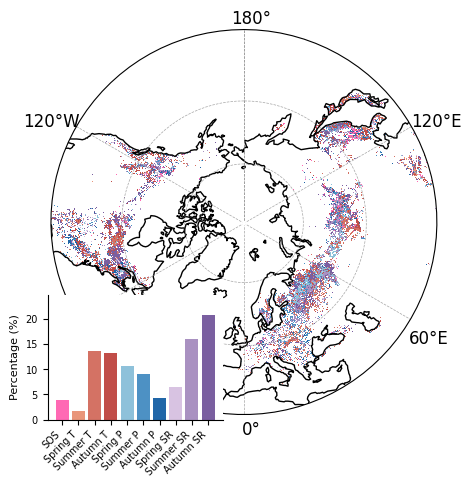

In [24]:
show_dominant_driver_map(effect_size)